# <center>Ridge Regression</center>
<center>DATA 558, Spring 2021</center>
<center>Author: Apoorv Sharma</center>

### 3.2 Gradient Descent

#### 3.2.1 - Trivial Case

$$F(\beta) = \frac{1}{2} (y - x\beta)^2 + \lambda \beta^2$$

$$\frac{dF}{d\beta} = [\frac{1}{2} \cdot 2 \cdot (y - x\beta) \cdot (-x)] + 2\lambda\beta$$

$$\therefore \frac{dF}{d\beta} = -x(y-x\beta) + 2\lambda\beta$$

#### 3.2.2 - Matrix Form

$$\frac{dF}{d\beta} = -\frac{1}{n}X^T(Y-X\beta) + \frac{2}{n}\lambda\beta$$

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Load the data
file = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv' 
penguins = pd.read_csv(file, sep=',', header=0)
penguins = penguins.dropna()

In [3]:
# Create our X matrix with the predictors and y vector with the response
X = penguins.drop('body_mass_g', axis=1) 
X = pd.get_dummies(X, drop_first=True)
y = penguins['body_mass_g']

In [4]:
# Divide the data into training and test sets. By default, 25% goes into the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Standardize the data

In [5]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler = preprocessing.StandardScaler().fit(y_train.values.reshape(-1, 1))
y_train_scaled = scaler.transform(y_train.values.reshape(-1, 1)).reshape((-1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).reshape((-1))

In [6]:
def computegrad(beta, lambda_, X, Y):
    n = len(X)
    return (-(1/n)*X.T.dot(Y-X.dot(beta)) + 2/len(X)*lambda_*beta)

In [7]:
def graddescent(initial_loc, lr, max_iters, lambda_, X, y, stopping_thresh=None):
    
    # Don't want to change the starting location
    beta = initial_loc
    beta_grad = computegrad(beta, lambda_, X, y)
    beta_list = [beta]
    
    # Keep descending for 'max_iters'
    i = 0
    while True:
        beta = beta - lr * beta_grad
        beta_list.append(beta)
        
        beta_grad = computegrad(beta, lambda_, X, y)
        i += 1
        
        if not stopping_thresh and i > max_iters: break
        elif stopping_thresh and np.linalg.norm(beta_grad) < stopping_thresh: break
    
    return np.array(beta_list)

In [8]:
def get_ridge_objective_values(beta, lambda_, X, Y):    
    n = len(X)
    return 1/(2 * n)*np.linalg.norm(Y-X.dot(beta))**2 + lambda_/len(X) * np.linalg.norm(beta)**2

In [9]:
def plot_objective_values(lambda_, X, y, lr=0.5, max_iters=1000, stopping_threshold=None):
    (N, p) = X.shape
    
    initial_beta = np.zeros(p)
    beta_list = graddescent(initial_beta, lr, max_iters, lambda_, X, y, stopping_threshold)
    
    objective_vals = [get_ridge_objective_values(b, lambda_, X, y) for b in beta_list]
    
    plt.figure(figsize=(10,5))
    
    plt.plot(objective_vals)
    plt.title(f'Ridge Object Values (lambda={lambda_}, lr={lr})')
    plt.xlabel('Iterations')
    plt.ylabel('Ridge Objective values')
    
    return beta_list[-1], objective_vals[-1]
    

#### 3.2.6 - Plotting the gradient descent algorithm

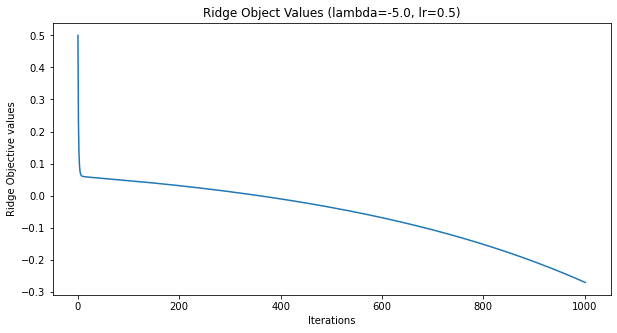

In [10]:
_, _ = plot_objective_values(
    lambda_=-5.00, 
    X=X_train_scaled, 
    y=y_train_scaled, 
    lr=0.5,
    max_iters=1000, 
    stopping_threshold=None
)

**Observation** : Here we can see that the objective values keep decreasing as the number of iterations increase. We can conclude that when $\lambda < 0$ (negative), the object function will diverge  

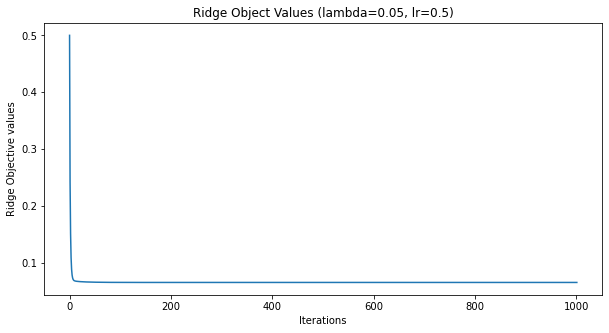

In [11]:
beta_T, beta_T_obj_val = plot_objective_values(
    lambda_= 0.05, 
    X = X_train_scaled, 
    y = y_train_scaled, 
    lr = 0.5,
    max_iters = 1000, 
    stopping_threshold = None
)

**Observation** : Here we can see that the objective values keep decreasing as the number of iterations increase. We can conclude that when $\lambda > 0$ (positive), the objective function will converge  

#### 3.2.8 - Comparing the imlementation to Sklearn

In [12]:
def compare_implementations(lambda_, X, y, lr, max_iters=1000, stopping_threshold=None, beta_T_to_compare=None):
    
    # Fit own implementation and get optimal values
    (N, p) = X.shape
    
    if beta_T_to_compare is None:
        initial_beta = np.zeros(p)
        beta_T = graddescent(initial_beta, lr, max_iters, lambda_, X, y, stopping_threshold)[-1]
    else:
        beta_T = beta_T_to_compare

    beta_T_obj_val = get_ridge_objective_values(beta_T, lambda_, X, y)
    
    model = Ridge(alpha=lambda_).fit(X_train_scaled, y_train_scaled)
    beta_star = model.coef_
    beta_star_obj_val = get_ridge_objective_values(beta_star, lambda_, X_train_scaled, y_train_scaled)
    
    print(f"beta_T:\n{beta_T}\n\n beta_star:\n{beta_star}")
    print(f"\nbeta_T obj : {beta_T_obj_val:.8f}\nbeta_star obj: {beta_star_obj_val:.8f}")
    
    return beta_T, beta_star, beta_T_obj_val, beta_star_obj_val

In [13]:
lambda_= 0.05
lr = 0.5
max_iters = 1000

In [14]:
beta_T, beta_star, beta_T_obj_val, beta_star_obj_val = compare_implementations( 
                                                                    lambda_= lambda_, 
                                                                    X = X_train_scaled, 
                                                                    y = y_train_scaled,
                                                                    lr = lr,
                                                                    max_iters = max_iters, 
                                                                    stopping_threshold = None, 
                                                                    beta_T_to_compare = beta_T
)

beta_T:
[ 0.10612898  0.1071633   0.27768522 -0.12516612  0.58926332 -0.00060885
 -0.03824052  0.27130432]

 beta_star:
[ 1.05726103e-01  1.07975282e-01  2.77200565e-01 -1.24846034e-01
  5.91031737e-01 -3.16965703e-04 -3.80511179e-02  2.71328189e-01]

beta_T obj : 0.06517434
beta_star obj: 0.06517444


**Observation** : Here we observe that the 2 $\beta$ values are similar. As a result, the objective values are the same as well when compared to the Sklearn library implementation.

#### 3.2.9 - Finding the optimal learning rate

In [15]:
lrs = np.logspace(-3, 1, 100)

max_iters = 1000
lambda_ = 0.05

In [16]:
def find_optimal_lr(lambda_, X, y, lrs, max_iters=1000, stopping_threshold=None):
    (N, p) = X.shape
    
    min_objective_value = float('inf')
    best_beta_t = None
    best_lr = 0

    for lr in tqdm(lrs):
        initial_beta = np.zeros(p)
        beta_T = graddescent(initial_beta, lr, max_iters, lambda_, X, y, stopping_threshold)[-1]
        beta_T_obj_val = get_ridge_objective_values(beta_T, lambda_, X, y)

        if beta_T_obj_val < min_objective_value:
            best_lr = lr
            best_beta_t = beta_T
            min_objective_value = beta_T_obj_val

    print(f"Best learning rate: {best_lr}\nLowest objective value: {min_objective_value:8f}")
    
    return best_lr, best_beta_t, min_objective_value

In [17]:
best_lr, best_beta_t, min_objective_value = find_optimal_lr(lambda_= lambda_, 
                                                            X = X_train_scaled, 
                                                            y = y_train_scaled,
                                                            lrs = lrs,
                                                            max_iters = max_iters, 
                                                            stopping_threshold = None
                                                           )

 76%|███████▌  | 76/100 [00:00<00:00, 83.57it/s]/Users/avsharma/opt/anaconda3/envs/DATA558/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in subtract
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 100/100 [00:01<00:00, 78.13it/s]

Best learning rate: 0.5094138014816381
Lowest objective value: 0.065174


In [18]:
beta_T, beta_star, beta_T_obj_val, beta_star_obj_val = compare_implementations( 
                                                                    lambda_= lambda_, 
                                                                    X = X_train_scaled, 
                                                                    y = y_train_scaled,
                                                                    lr = best_lr,
                                                                    max_iters = max_iters, 
                                                                    stopping_threshold = None, 
                                                                    beta_T_to_compare = best_beta_t
)

beta_T:
[ 0.10612898  0.1071633   0.27768522 -0.12516612  0.58926332 -0.00060885
 -0.03824052  0.27130432]

 beta_star:
[ 1.05726103e-01  1.07975282e-01  2.77200565e-01 -1.24846034e-01
  5.91031737e-01 -3.16965703e-04 -3.80511179e-02  2.71328189e-01]

beta_T obj : 0.06517434
beta_star obj: 0.06517444


**Observation** : Here we see that the best learning rate is approximately $0.5$. Thus, we obtain very similar $\beta$ values as we did previously. 

#### 3.2.10 - Changing the stopping criteria

##### 3.2.10.1 - Plot for specified lambda value

In [19]:
lambda_= 0.05
lr = 0.5
max_iters = 1000
epsilon = 0.005

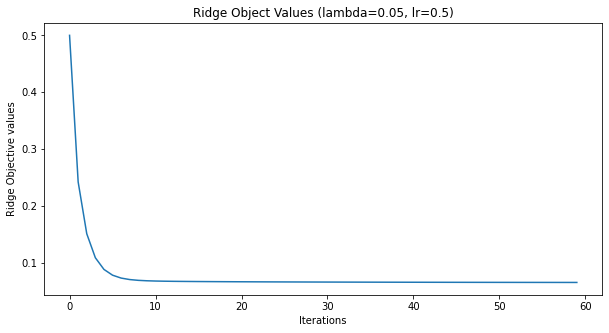

In [20]:
beta_T, beta_T_obj_val = plot_objective_values(
    lambda_= 0.05, 
    X = X_train_scaled, 
    y = y_train_scaled, 
    lr = 0.5,
    max_iters = 1000, 
    stopping_threshold = epsilon
)

**Observation** : Here the curve is a lot smoother since we do less iterations. This shows that our algorithm converges in close to 60 iterations

##### 3.2.10.2 - Compare implementations

In [21]:
beta_T, beta_star, beta_T_obj_val, beta_star_obj_val = compare_implementations(
                                                                    lambda_= lambda_, 
                                                                    X = X_train_scaled, 
                                                                    y = y_train_scaled,
                                                                    lr = lr,
                                                                    max_iters = max_iters, 
                                                                    stopping_threshold = epsilon, 
                                                                    beta_T_to_compare = beta_T
)

beta_T:
[ 0.13176938  0.06202545  0.31383182 -0.1504637   0.48397455 -0.01244517
 -0.04817534  0.26991908]

 beta_star:
[ 1.05726103e-01  1.07975282e-01  2.77200565e-01 -1.24846034e-01
  5.91031737e-01 -3.16965703e-04 -3.80511179e-02  2.71328189e-01]

beta_T obj : 0.06548444
beta_star obj: 0.06517444


**Observation** : The $\beta$ values are now slightly less compared to the library implementation. Consequently, the ridge objective value comes out to be a little higher.

##### 3.2.10.3 - Finding optimal learning rate

In [22]:
# Algorithm takes a long time to converge for lr values > 0.65. Thus, we remove those from the list of values
lrs_2 = [x for x in np.logspace(-3, 0, 50) if x <= 0.65]

In [23]:
best_lr, best_beta_t, min_objective_value = find_optimal_lr(lambda_= lambda_, 
                                                            X = X_train_scaled, 
                                                            y = y_train_scaled,
                                                            lrs = lrs_2,
                                                            max_iters = max_iters, 
                                                            stopping_threshold = epsilon
                                                           )

100%|██████████| 46/46 [00:04<00:00,  9.58it/s]

Best learning rate: 0.5689866029018293
Lowest objective value: 0.065238


In [24]:
beta_T, beta_star, beta_T_obj_val, beta_star_obj_val = compare_implementations( 
                                                                    lambda_= lambda_, 
                                                                    X = X_train_scaled, 
                                                                    y = y_train_scaled,
                                                                    lr = lr,
                                                                    max_iters = max_iters, 
                                                                    stopping_threshold = None, 
                                                                    beta_T_to_compare = best_beta_t
)

beta_T:
[ 0.11780654  0.08800203  0.29307841 -0.13665748  0.54177415 -0.00521712
 -0.04244717  0.27045605]

 beta_star:
[ 1.05726103e-01  1.07975282e-01  2.77200565e-01 -1.24846034e-01
  5.91031737e-01 -3.16965703e-04 -3.80511179e-02  2.71328189e-01]

beta_T obj : 0.06523843
beta_star obj: 0.06517444


**Observation** : Once we change the condition for the stopping threshold and attempt to find the optimal learning rate, we observe that the new condition yields a slightly higher lr of $0.568$.

As a result, the objective function is slightly higher compared to the library implementation. 

### Exercise 4

In [25]:
import statsmodels.api as sm

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [26]:
df = pd.read_csv("https://www.statlearning.com/s/Auto.csv", na_values ='?')
df.dropna(inplace=True)

In [27]:
X = sm.add_constant(df['weight'])
y = df['mpg']

In [28]:
model = sm.OLS(y, X)
results = model.fit()

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     878.8
Date:                Fri, 30 Apr 2021   Prob (F-statistic):          6.02e-102
Time:                        18:31:33   Log-Likelihood:                -1130.0
No. Observations:                 392   AIC:                             2264.
Df Residuals:                     390   BIC:                             2272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.2165      0.799     57.867      0.000      44.646      47.787
weight        -0.0076      0.000    -29.645      0.000      -0.008      -0.007
==============================================================================
Omnibus:                       41.682   Durbin-Watson:                   0.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.039
Skew:                           0.727   Prob(JB):                     9.18e-14
Kurtosis:                       4.251   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

(i)

The p-value of the F statistic is $6.02e-102$, thus we reject the null hypothesis. Thus, we can conclude that there is a relationship between weight and mpg

(ii)

The $R^2$ value is $0.693$. This implies that $69.3$% of the variance in mpg is due to weight

(iii)

The correlation coefficient is negative, $-0.0076$. Therefore, we can say that there is a negative relationship between the predictor and response variables 

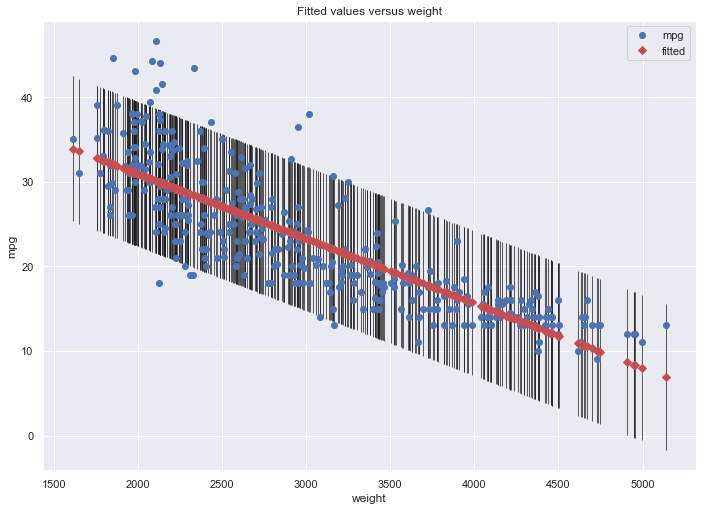

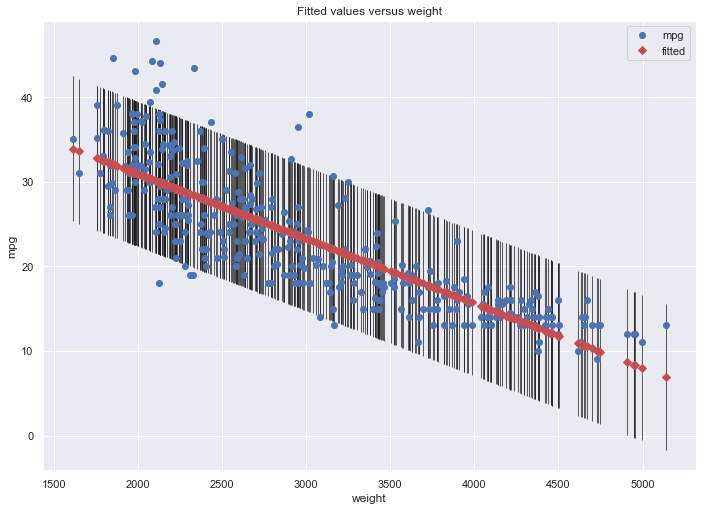

In [30]:
import statsmodels as sm
sm.graphics.regressionplots.plot_fit(results, exog_idx=1)

/Users/avsharma/opt/anaconda3/envs/DATA558/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


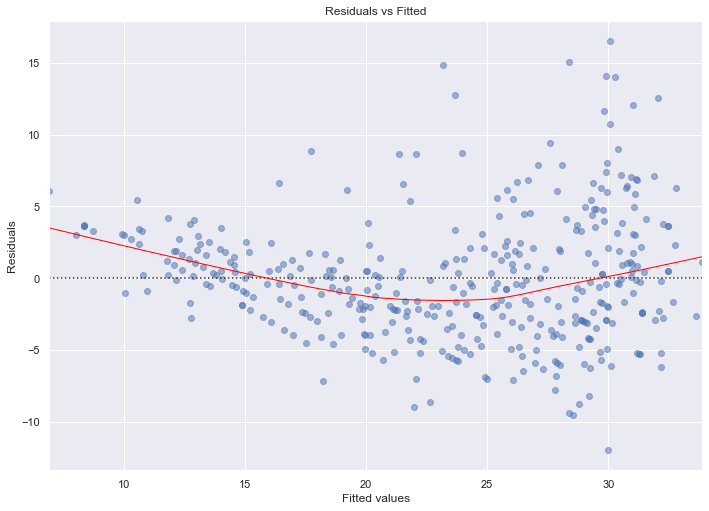

In [31]:
'''
Code Reference:
https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
'''

fitted = results.fittedvalues
plot = plt.figure()
plot.axes[0] = sns.residplot(fitted, 'mpg', data=df, lowess=True, scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
txt = plot.axes[0].set_title('Residuals vs Fitted')
txt = plot.axes[0].set_xlabel('Fitted values')
txt = plot.axes[0].set_ylabel('Residuals')

Since the data points are more scattered with higher fitted values, this implies that the data maybe non-linear